# 기본적인 Setting (Google drive mount, import libraires, cuda) 

In [1]:
#source: https://github.com/LightersWang/3DUNet-BraTS-PyTorch/blob/master/utils/misc.py
!apt-get install libboost-python-dev build-essential
!pip install medpy
!pip install monai
!pip install ipyvolume
!pip install -Uqq ipdb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-python-dev is already the newest version (1.71.0.0ubuntu2).
libboost-python-dev set to manually installed.
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 34.2 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214946 sha256=5113f44055b9dbac8da6322cb97083f14db36d18775816345b989ed5f90a03ec
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-w

In [2]:
##### Google drive mount #####
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/졸업설계2"

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1J0xu1jUvayiGj-HtrsoiVD-z2Mws4Qss/졸업설계2


In [3]:
class AverageMeter (object):
    def __init__(self):
        self.reset ()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
##### Import libraries #####
import torch
import pandas as pd
import nibabel as nib 
import os
from tqdm.auto import tqdm #https://velog.io/@jj770206/AssertionError-can-only-join-a-child-process
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import ipdb
from medpy.metric import hd95 as hd95_medpy
from monai.metrics import compute_hausdorff_distance
from torch import Tensor
from collections import defaultdict
from sklearn.metrics import f1_score
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import time
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.colors as colors
from skimage import measure
import ipyvolume as ipv
from mpl_toolkits.mplot3d import Axes3D
from decimal import *
from PIL import Image

##### Cuda Setting #####
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi


Wed May 17 10:52:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data processing



In [5]:
##### (Class) Dataset #####
class Dataset(Dataset):
    def __init__(self, datapath = '/content/drive/MyDrive/졸업설계2/3D_dataset/'):#한번 만든 뒤에 datapath 고정
        self.folderpaths = {
                              'mask': os.path.join(datapath, 'seg/'),
                              't1ce': os.path.join(datapath, 't1ce/'),
                              't2': os.path.join(datapath, 't2/'),
                              'flair': os.path.join(datapath, 'flair/')
                          }
    
    def __getitem__(self, idx):
        images = {}#dictionary 자료형
        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        for name in images:
            images[name] = torch.from_numpy(images[name])#numpy array tensor로, 값 변경하면 반영됨

        # stacking multi ins, image 새로운 차원으로 쌇음
        input = torch.stack(
          
                                [
                                images['t1ce'],
                                images['t2'],
                                images['flair']], dim = 0
                            )
        images['mask'][images['mask'] == 4] = 3
        #one-hot encoding truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0, 4, 1, 2, 3).contiguous().squeeze(0)
        return input.float(), images['mask'].long()
    #squeeze, (A x B x 1 x C x 1) 형태의 텐서에서 지정한 차원이 1인 부분을 제거하여 (A x B x C) 형태로 만들어 주는 것
    #unsqueeze는 지정한 차원에 1 만들어줘서 차원 늘림
    #permute().contiguous는 같이 사용, 차원 순서 교체
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

##### Validation data, Test data and Train data의 분리 #####
valid_test_dataset = Dataset(datapath = '/content/drive/MyDrive/졸업설계2/3D_dataset/')
train_dataset = Dataset(datapath = '/content/drive/MyDrive/졸업설계2/3D_dataset/')
                        
train_length=int(0.6 * len(valid_test_dataset)) #60%는 train data로
valid_length = int(0.2 * len(valid_test_dataset)) #20%는 validation data로
test_length = len(valid_test_dataset) - train_length - valid_length #20%는 test data로

_ , valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42)) #랜덤하게 데이터분할
train_dataset, _ , _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))  


train_loader = DataLoader(train_dataset,
                      batch_size=4,
                      num_workers=4,
                      shuffle=True)
# num_workers=(batch_size/num_cpus) 

valid_loader = DataLoader(valid_dataset,
                      batch_size=4,
                      num_workers=4,
                      shuffle=False)

test_loader = DataLoader(test_dataset,
                      batch_size=4,
                      num_workers=4,
                      shuffle=False)

# a, b = next(iter(train_loader)) #왜 필요한거지?? 일단 없어져도 무리X

(3, 128, 128, 128)
(4, 128, 128, 128)
[[-1.0372491  -1.0372491  -1.0372491  ... -1.0372491  -1.0372491
  -1.0372491 ]
 [-1.0372491  -1.0372491  -1.0372491  ... -1.0372491  -1.0372491
  -1.0372491 ]
 [-1.0372491  -1.0372491  -1.0372491  ... -1.0372491  -1.0372491
  -1.0372491 ]
 ...
 [ 0.84196323  0.84196323  0.84196323 ... -1.0372491  -1.0372491
  -1.0372491 ]
 [ 0.7850174   0.79722005  0.80942273 ... -1.0372491  -1.0372491
  -1.0372491 ]
 [ 0.62231505  0.6955311   0.7646796  ... -1.0372491  -1.0372491
  -1.0372491 ]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


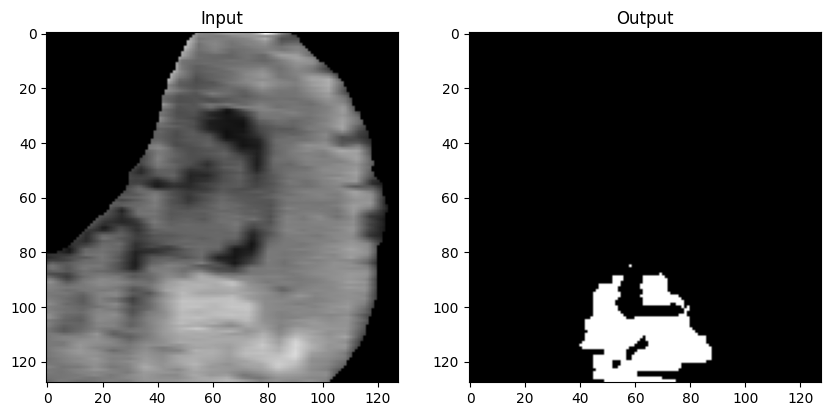

In [48]:
#Just for test. please delete it
torch.set_printoptions(profile="full")
t_inputs, t_labels = train_dataset[0]
print(t_inputs.numpy().shape)
print(t_labels.numpy().shape)

input = (t_inputs.numpy())[2][50]
label = (t_labels.numpy())[3][50]
print(input)
print(label)
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('Input')
plt.imshow(input, cmap='gray', aspect='auto')
plt.subplot(222)
plt.title('Output')
plt.imshow(label, cmap='gray', aspect='auto')
plt.show()


# Model Building


In [ ]:
# 3D-UNet model.
# x: 128x128 resolution for 32 frames.

##### Model building을 위한 기본적인 Method #####
def conv_block_3d(in_dim, out_dim, activation):
    return nn.Sequential(
        nn.Conv3d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_dim),
        activation,)


def conv_trans_block_3d(in_dim, out_dim, activation):
    return nn.Sequential(
        nn.ConvTranspose3d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm3d(out_dim),
        activation,)


def max_pooling_3d():
    return nn.MaxPool3d(kernel_size=2, stride=2, padding=0)


def conv_block_2_3d(in_dim, out_dim, activation):
    return nn.Sequential(
        conv_block_3d(in_dim, out_dim, activation),
        nn.Conv3d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_dim),)

##### (Class) UNet #####
class UNet(nn.Module):
    def __init__(self, in_dim, out_dim, num_filters):
        super(UNet, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filters = num_filters
        activation = nn.LeakyReLU(0.0001, inplace=True) #Activation 선택에 있어서 norm Lelu라는 것도 있는데?
        
        # Down sampling
        self.down_1 = conv_block_2_3d(self.in_dim, self.num_filters, activation)
        self.pool_1 = max_pooling_3d()
        self.down_2 = conv_block_2_3d(self.num_filters, self.num_filters * 2, activation)
        self.pool_2 = max_pooling_3d()
        self.down_3 = conv_block_2_3d(self.num_filters * 2, self.num_filters * 4, activation)
        self.pool_3 = max_pooling_3d()
        self.down_4 = conv_block_2_3d(self.num_filters * 4, self.num_filters * 8, activation)
        self.pool_4 = max_pooling_3d()
        self.down_5 = conv_block_2_3d(self.num_filters * 8, self.num_filters * 16, activation)
        self.pool_5 = max_pooling_3d()
        
        # Bridge
        self.bridge = conv_block_2_3d(self.num_filters * 16, self.num_filters * 32, activation)
        
        # Up sampling
        self.trans_1 = conv_trans_block_3d(self.num_filters * 32, self.num_filters * 32, activation)
        self.up_1 = conv_block_2_3d(self.num_filters * 48, self.num_filters * 16, activation)
        self.trans_2 = conv_trans_block_3d(self.num_filters * 16, self.num_filters * 16, activation)
        self.up_2 = conv_block_2_3d(self.num_filters * 24, self.num_filters * 8, activation)
        self.trans_3 = conv_trans_block_3d(self.num_filters * 8, self.num_filters * 8, activation)
        self.up_3 = conv_block_2_3d(self.num_filters * 12, self.num_filters * 4, activation)
        self.trans_4 = conv_trans_block_3d(self.num_filters * 4, self.num_filters * 4, activation)
        self.up_4 = conv_block_2_3d(self.num_filters * 6, self.num_filters * 2, activation)
        self.trans_5 = conv_trans_block_3d(self.num_filters * 2, self.num_filters * 2, activation)
        self.up_5 = conv_block_2_3d(self.num_filters * 3, self.num_filters * 1, activation)
        
        # Output
        self.out = conv_block_3d(self.num_filters, out_dim,  nn.ReLU())
    
    def forward(self, x):
        # Down sampling
        down_1 = self.down_1(x) # -> [1, 4, 128, 128, 128]
        pool_1 = self.pool_1(down_1) # -> [1, 4, 64, 64, 64]
        
        down_2 = self.down_2(pool_1) # -> [1, 8, 64, 64, 64]
        pool_2 = self.pool_2(down_2) # -> [1, 8, 32, 32, 32]
        
        down_3 = self.down_3(pool_2) # -> [1, 16, 32, 32, 32]
        pool_3 = self.pool_3(down_3) # -> [1, 16, 16, 16, 16]
        
        down_4 = self.down_4(pool_3) # -> [1, 32, 16, 16, 16]
        pool_4 = self.pool_4(down_4) # -> [1, 32, 8, 8, 8]
        
        down_5 = self.down_5(pool_4) # -> [1, 64, 8, 8, 8]
        pool_5 = self.pool_5(down_5) # -> [1, 64, 4, 4, 4]
        
        # Bridge
        bridge = self.bridge(pool_5) # -> [1, 128, 4, 4, 4]
        
        # Up sampling
        trans_1 = self.trans_1(bridge) # -> [1, 128, 8, 8, 8]
        concat_1 = torch.cat([trans_1, down_5], dim=1) # -> [1, 192, 8, 8, 8]
        up_1 = self.up_1(concat_1) # -> [1, 64, 8, 8, 8]
        
        trans_2 = self.trans_2(up_1) # -> [1, 64, 16, 16, 16]
        concat_2 = torch.cat([trans_2, down_4], dim=1) # -> [1, 96, 16, 16, 16]
        up_2 = self.up_2(concat_2) # -> [1, 32, 16, 16, 16]
        
        trans_3 = self.trans_3(up_2) # -> [1, 32, 32, 32, 32]
        concat_3 = torch.cat([trans_3, down_3], dim=1) # -> [1, 48, 32, 32, 32]
        up_3 = self.up_3(concat_3) # -> [1, 16, 32, 32, 32]
        
        trans_4 = self.trans_4(up_3) # -> [1, 16, 64, 64, 64]
        concat_4 = torch.cat([trans_4, down_2], dim=1) # -> [1, 24, 64, 64, 64]
        up_4 = self.up_4(concat_4) # -> [1, 8, 64, 64, 64]
        
        trans_5 = self.trans_5(up_4) # -> [1, 8, 128, 128, 128]
        concat_5 = torch.cat([trans_5, down_1], dim=1) # -> [1, 12, 128, 128, 128]
        up_5 = self.up_5(concat_5) # -> [1, 4, 128, 128, 128]
        
        # Output
        out = self.out(up_5) # -> [1, 4, 128, 128, 128]
        return out



##### Finally, Build model #####
model = UNet(in_dim=3, out_dim=4, num_filters=4)

In [ ]:
##### Uncomment this if you want to load parameter #####
#model.load_state_dict(torch.load('./model.pth')) #모델을 불러오고 싶을때 이 코드 주석을 풀기

# Loss

In [ ]:
def dice_loss(y_pred, y_true, smooth=0.000001):
    temp_pred = y_pred.clone()
    temp_true = y_true.clone()
    temp_pred = torch.tanh(temp_pred)
    temp_pred = temp_pred.contiguous().view(-1).float()
    temp_true = temp_true.contiguous().view(-1).float()
    intersection = (temp_pred * temp_true).sum()
    dice = (2 * intersection + smooth) / (temp_pred.sum() + temp_true.sum() + smooth)
    return 1 - dice

# Metric

In [ ]:
def calculate_fscore(model, outputs, labels):
    model.eval()
    with torch.no_grad():
        temp_outputs = outputs.clone()
        temp_labels = labels.clone()
        temp_outputs =(temp_outputs > 0).float() # 0을 기준으로 이진화
        temp_outputs = temp_outputs.cpu().numpy() # 배치 크기를 제거하고, CPU로 이동
        temp_labels = temp_labels.float().cpu().numpy() # CPU로 이동
        fscore = f1_score(temp_labels.flatten(), temp_outputs.flatten(), average='binary')
        return fscore

# Optimizer

In [ ]:
import torch.optim as optim

# optimizer 설정
learning_rate = 0.1
betas = (0.9, 0.999)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2)

# Train & Validate model

In [ ]:
#train_len = list(enumerate(train_loader))[-1][0] # To reduce resources
#valid_len = list(enumerate(valid_loader))[-1][0] # To reduce resources

max_fscore = 0.0
max_iouscore = 0.0
min_v_loss = 100.0
iou_scores = []
f_scores = []
train_losses = []
valid_losses = []

g_input = None
g_output = None
g_label = None

#print("TRAIN PROCESS: %d cycle per epoch" % train_len) #To reduce resources
#print("VALIDATE PROCESS: %d cycle per epoch" % valid_len) #To reduce resources

In [ ]:
#Train and validate model
#주요 실험 포인트: 컴퓨팅단위를 아끼기 위해 epoch를 1로 바꾸고, fscore는 계산하지 않음(모두 주석처리)

max_epoch = 20
dup_vloss_cnt = 0
prev_vloss = 0

for epoch in range(max_epoch): 
  start = time.time()
  print(f'\n === EPOCH {epoch} ===')
  t_loss_meter = AverageMeter()
  v_loss_meter = AverageMeter()
  fscore_meter = AverageMeter()
  iouscore_meter = AverageMeter()

  #Train process
  for i, t_data in enumerate(train_loader):
    print('■', end='')
    if i % 10 == 9:
      print('')
    t_inputs, t_labels = t_data
    t_outputs = model(t_inputs)
    t_loss = dice_loss(t_outputs,t_labels)
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()
    t_loss_meter.update(t_loss.item())  
  print(f"\nTrain Dice Loss Average:{t_loss_meter.avg: .15f} ", end=' / ') #(Take Note) Loss는 위 loop를 지날때 마다 평가되며, 이들의 평균을 출력함 
  train_losses.append(t_loss_meter.avg)

 #Validate process (학습을 진행하지 않음)
  for j, v_data in enumerate(valid_loader):
    v_inputs, v_labels = v_data
    v_outputs = model(v_inputs)
    v_loss = dice_loss(v_outputs, v_labels)
    v_loss_meter.update(v_loss.item())
    fscore = calculate_fscore(model, v_outputs, v_labels)
    fscore_meter.update(fscore)
  scheduler.step(v_loss_meter.avg)
  print(f"Valid Dice Loss Average: {v_loss_meter.avg: .15f}")  #(Take Note) Loss와 fscore, iouscore는 위 loop를 지날때 마다 평가되며, 이들의 평균을 출력함
  valid_losses.append(v_loss_meter.avg)
  print(f"f-score Average: {fscore_meter.avg: .15f}", end=' / ')
  f_scores.append(fscore_meter.avg)
  end = time.time()
  print(f"Elasped Time: {end - start:.5f} sec")
  
  #만약 iouscore 평균이 epoch들 중에서 max값이면 model을 저장함
  if v_loss_meter.avg < min_v_loss:
    min_v_loss = v_loss_meter.avg
    torch.save(model.state_dict(), f'./model.pth')
    for j, v_data in enumerate(valid_loader):
       g_input = v_inputs
       g_output = v_outputs
       g_label = v_labels
       break
    print("Model Saved!")


 === EPOCH 0 ===
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■
Train Dice Loss Average: 0.333770145069469  / Valid Dice Loss Average:  0.307596605075033
f-score Average:  0.772122896881210 / Elasped Time: 995.14556 sec

 === EPOCH 1 ===
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■
Train Dice Loss Average: 0.058104407787323  / Valid Dice Loss Average:  0.050333826165450
f-score Average:  0.949666173834550 / Elasped Time: 972.25411 sec

 === EPOCH 2 ===
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■
Train Dice Loss Average: 0.044664272395047  / Valid Dice Loss Average:  0.050333826165450
f-score Average:  0.949666173834550 / Elasped Time: 973.96970 sec

 === EPOCH 3 ===
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■
Train Dice Loss Average: 0.044664272395047  / Valid Dice Loss Average:  0.050333826165450
f-score Average:  0.949666173834550 / Elasped Time: 968.31062 sec

 === EPOCH 4 ===
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■■
■■■■■■■■■

KeyboardInterrupt: ignored

# Plot & Visualize model


In [ ]:
torch.set_printoptions(profile="full")
print(g_output[0][0][50])
#결론: 학습이 중단되는 이유는 그냥 다 맞췄기 때문이다. (그냥 0과 1사이로 나옴)

print(g_label[0][0][50])

In [ ]:
#Visualize the model (Stuck point..)
# 3D slice 중 하나 선택
slice_idx = 16

# 시각화할 slice 추출
label_slice = g_label[0, 0, 50,:, :]
output_slice = g_output[0, 0, 50, :, :]

# 이진화
binarized_output = torch.where(output_slice > 0, torch.ones_like(output_slice), torch.zeros_like(output_slice))
print(binarized_output)

# 시각화할 slice index 선택

# 시각화
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('Label')
plt.imshow(label_slice, cmap='gray', aspect='auto')
plt.subplot(222)
plt.title('Output')
plt.imshow(binarized_output, cmap='gray', aspect='auto')
plt.show()

In [ ]:
#plot the result
plt.plot(range(1, len(train_losses)+1), train_losses, 'b', label='train loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, 'orange', label='valid loss')
plt.xticks(np.arange(1, max_epoch + 1))
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, len(f_scores)+1), f_scores, 'b')
plt.title('Epoch vs f Score')
plt.xlabel('Epoch')
plt.ylabel('f Score')
plt.show()